# Multi-Snapshot GP Emulation
Training and emulation across multiple snapshots (redshifts) for cosmological hydrodynamic summary statistics.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os

from cosmo_hydro_emu.pca import *
from cosmo_hydro_emu.viz import *
from cosmo_hydro_emu.load_hacc import *
from cosmo_hydro_emu.emu import *
from cosmo_hydro_emu.gp import *
from cosmo_hydro_emu.snapshot_utils import *

# Configuration & Parameters

In [2]:
DirIn = '../data/400MPC_RUNS_5SG_2COSMO_PARAM/HAvoCC/'

start_sim_idx = 1
num_sims = 39
exp_variance = 0.999

z_initial = 200  # Initial redshift of simulation

do_train = False

In [3]:
def read_params(fileIn):
    params_all = np.loadtxt(fileIn, delimiter=",", skiprows=1)
    start_sim_idx = 1
    end_sim_idx = 40
    print('Loaded file with params: ', params_all.shape)
    return params_all[start_sim_idx:end_sim_idx]

fileIn = '/home/nramachandra/Projects/Hydro_runs/CosmoHydro/data/FinalDesign.txt'
params32 = read_params(fileIn)

seed_mass_scale = 1e6
vkin_scale = 1e4
eps_scale = 1e1

params32[:, 2] = params32[:, 2] / seed_mass_scale
params32[:, 3] = params32[:, 3] / vkin_scale
params32[:, 4] = params32[:, 4] / eps_scale

PARAM_NAME = ['$\\kappa_\\text{w}$',
              '$e_\\text{w}$',
              '$M_\\text{seed}/10^{6}$',
              '$v_\\text{kin}/10^{4}$',
              '$\\epsilon_\\text{kin}/10^{1}$',
              '$\\omega_\\text{m}$',
              '$\\sigma_\\text{8}$']

print('params32 shape:', params32.shape)

Loaded file with params:  (110, 7)
params32 shape: (39, 7)


In [4]:
# Train/test split: hold out 5 sims for proper validation
test_sim_indices = np.array([3, 11, 19, 27, 35])
train_sim_indices = np.array([i for i in range(num_sims) if i not in test_sim_indices])

params_train = params32[train_sim_indices]
params_test = params32[test_sim_indices]

print(f'Train: {len(train_sim_indices)} sims, Test: {len(test_sim_indices)} sims')
print(f'Test sim indices: {test_sim_indices}')

Train: 34 sims, Test: 5 sims
Test sim indices: [ 3 11 19 27 35]


# Snapshot Setup

Number of snapshots: 11
Snapshot IDs: [205, 224, 247, 275, 310, 355, 415, 479, 498, 567, 624]
Redshift range: z = 0.00 to 2.00
Scale factor range: a = 0.333 to 1.000


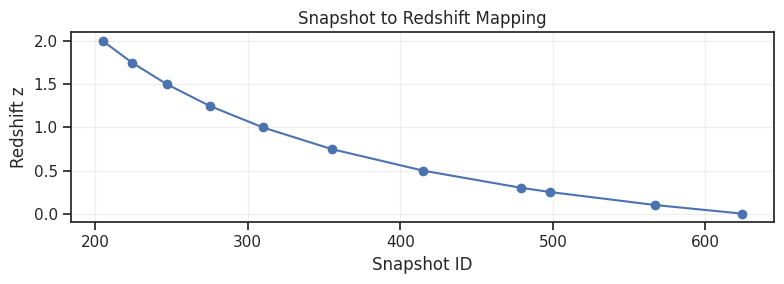

In [5]:
z_all, a_all = get_snapshot_redshifts(SNAPSHOT_IDS, z_initial=z_initial)

print(f'Number of snapshots: {len(SNAPSHOT_IDS)}')
print(f'Snapshot IDs: {SNAPSHOT_IDS}')
print(f'Redshift range: z = {z_all[-1]:.2f} to {z_all[0]:.2f}')
print(f'Scale factor range: a = {a_all[0]:.3f} to {a_all[-1]:.3f}')

plt.figure(figsize=(8, 3))
plt.plot(SNAPSHOT_IDS, z_all, 'o-')
plt.xlabel('Snapshot ID')
plt.ylabel('Redshift z')
plt.title('Snapshot to Redshift Mapping')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Load Data -- All Snapshots

In [6]:
stellar_mass, gsmf_arr_all = read_gsmf_all_snaps(DirIn, num_sims, SNAPSHOT_IDS, start_sim_idx=start_sim_idx)
print(f'GSMF: stellar_mass {stellar_mass.shape}, gsmf_arr {gsmf_arr_all.shape}')

log_halo_mass, gas_fr_arr_all = read_gasfr_all_snaps(DirIn, num_sims, SNAPSHOT_IDS, start_sim_idx=start_sim_idx)
print(f'fGas: log_halo_mass {log_halo_mass.shape}, gas_fr_arr {gas_fr_arr_all.shape}')

radius, cgd_arr_all = read_cgd_all_snaps(DirIn, num_sims, SNAPSHOT_IDS, start_sim_idx=start_sim_idx)
print(f'CGD: radius {radius.shape}, cgd_arr {cgd_arr_all.shape}')

radius, cged_arr_all = read_cged_all_snaps(DirIn, num_sims, SNAPSHOT_IDS, start_sim_idx=start_sim_idx)
print(f'CGED: radius {radius.shape}, cged_arr {cged_arr_all.shape}')

GSMF: stellar_mass (39,), gsmf_arr (39, 11, 39)
fGas: log_halo_mass (20,), gas_fr_arr (39, 11, 20)
CGD: radius (19,), cgd_arr (39, 11, 19)
CGED: radius (19,), cged_arr (39, 11, 19)


# Visualize -- Summary Stats at Multiple Snapshots

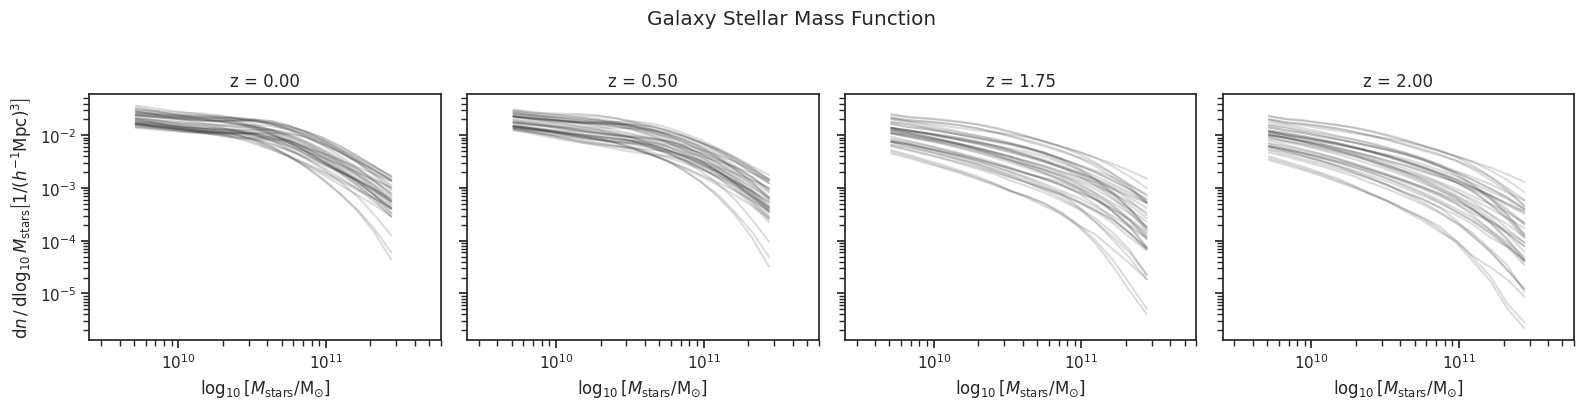

In [7]:
snap_indices_to_plot = [-1, -5, -10, 0]  # z for CGD only valid until z=2.0
color_by_index = 0

fig, axes = plt.subplots(1, len(snap_indices_to_plot), figsize=(4*len(snap_indices_to_plot), 4), sharey=True)

plt_strings = plot_strings('GSMF')
mlim1, mlim2 = mass_conds('GSMF')

for i, snap_idx in enumerate(snap_indices_to_plot):
    ax = axes[i]
    z_snap = z_all[snap_idx]
    
    for sim_i in range(num_sims):
        mass_cond = (stellar_mass > mlim1) & (stellar_mass < mlim2)
        ax.plot(stellar_mass[mass_cond], gsmf_arr_all[sim_i, snap_idx, mass_cond], 'k-', alpha=0.15)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'z = {z_snap:.2f}')
    ax.set_xlabel(plt_strings[1])
    if i == 0:
        ax.set_ylabel(plt_strings[2])
    ax.set_xlim(0.5*mlim1, 2*mlim2)

plt.suptitle('Galaxy Stellar Mass Function', y=1.02)
plt.tight_layout()
plt.savefig('../plots/GSMF_multiz.png', bbox_inches='tight')

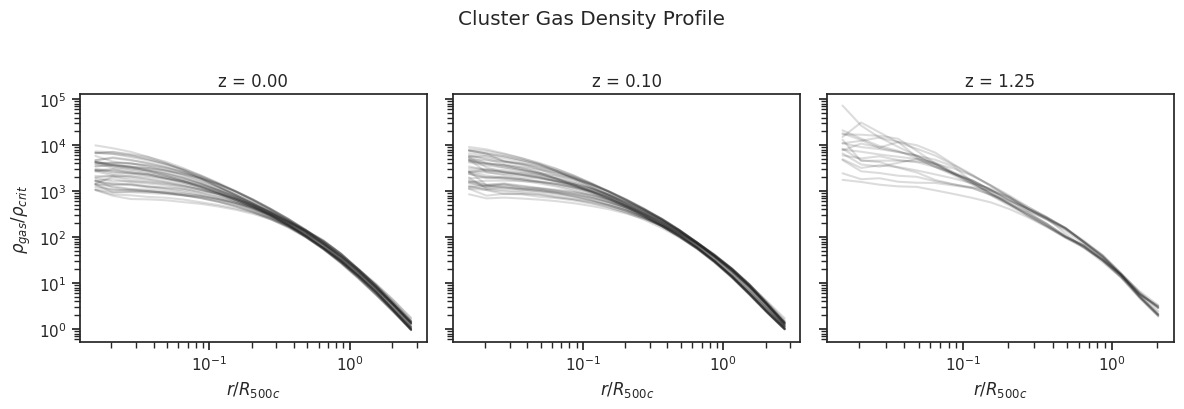

In [8]:
snap_indices_to_plot = [-1, -2, -8]  # z for CGD only valid until z=1.25
color_by_index = 4

fig, axes = plt.subplots(1, len(snap_indices_to_plot), figsize=(4*len(snap_indices_to_plot), 4), sharey=True)

for i, snap_idx in enumerate(snap_indices_to_plot):
    ax = axes[i]
    z_snap = z_all[snap_idx]
    
    for sim_i in range(num_sims):
        ax.plot(radius, cgd_arr_all[sim_i, snap_idx, :], 'k-', alpha=0.15)
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'z = {z_snap:.2f}')
    ax.set_xlabel(r'$r/R_{500c}$')
    if i == 0:
        ax.set_ylabel(r'$\rho_{gas} / \rho_{crit}$')

plt.suptitle('Cluster Gas Density Profile', y=1.02)
plt.tight_layout()
plt.savefig('../plots/CGD_multiz.png', bbox_inches='tight')

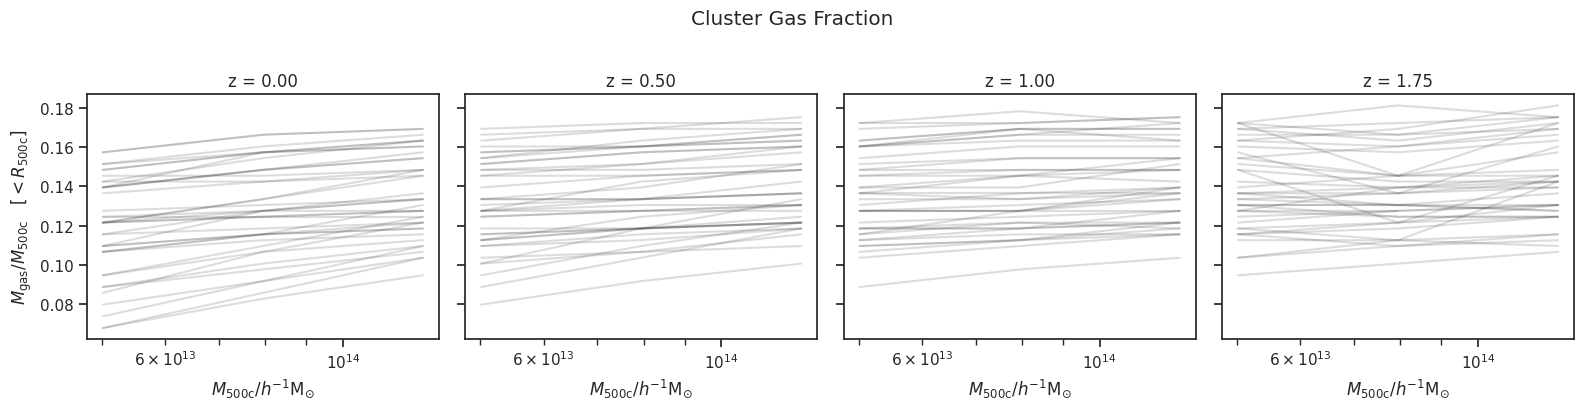

In [9]:
snap_indices_to_plot = [-1, -5, -7, -10]  # fGas: valid from z~1.0 onward, z~2.0 has 20/39 bad sims
color_by_index = 0

plt_strings_fgas = plot_strings('fGas')
mlim1_fg, mlim2_fg = mass_conds('fGas')

fig, axes = plt.subplots(1, len(snap_indices_to_plot), figsize=(4*len(snap_indices_to_plot), 4), sharey=True)

for i, snap_idx in enumerate(snap_indices_to_plot):
    ax = axes[i]
    z_snap = z_all[snap_idx]
    
    for sim_i in range(num_sims):
        mass_cond_fg_plt = (10**log_halo_mass > mlim1_fg) & (10**log_halo_mass < mlim2_fg)
        ax.plot(10**log_halo_mass[mass_cond_fg_plt], gas_fr_arr_all[sim_i, snap_idx, mass_cond_fg_plt], 'k-', alpha=0.15)
    
    ax.set_xscale('log')
    ax.set_title(f'z = {z_snap:.2f}')
    ax.set_xlabel(plt_strings_fgas[1])
    if i == 0:
        ax.set_ylabel(plt_strings_fgas[2])

plt.suptitle('Cluster Gas Fraction', y=1.02)
plt.tight_layout()
plt.savefig('../plots/fGas_multiz.png', bbox_inches='tight')

# Emulate GSMF -- All Snapshots

In [10]:
# Data prep for GSMF
plt_strings = plot_strings('GSMF')
mlim1, mlim2 = mass_conds('GSMF')
mass_cond = np.where((stellar_mass > mlim1) & (stellar_mass < mlim2))[0]

# Apply mass cut and interpolation for all snapshots
gsmf_y_ind = stellar_mass[mass_cond]

# Prepare 3D array for training: (num_sims, num_snaps, num_bins_cut)
gsmf_y_vals = np.zeros((num_sims, len(SNAPSHOT_IDS), len(mass_cond)))
for snap_idx in range(len(SNAPSHOT_IDS)):
    gsmf_snap = gsmf_arr_all[:, snap_idx, :]
    gsmf_snap_extra = fill_nan_with_interpolation(gsmf_snap, 'linear')
    gsmf_y_vals[:, snap_idx, :] = 10**gsmf_snap_extra[:, mass_cond]

print(f'GSMF training data: {gsmf_y_vals.shape}')
print(f'  (num_sims={gsmf_y_vals.shape[0]}, num_snaps={gsmf_y_vals.shape[1]}, num_bins={gsmf_y_vals.shape[2]})')

GSMF training data: (39, 11, 16)
  (num_sims=39, num_snaps=11, num_bins=16)


### Train GP for GSMF (all snapshots)

In [11]:
# Train GP models for all snapshots (using TRAIN set only)
model_dir_gsmf = 'model/GSMF/'

if do_train:
    os.makedirs(model_dir_gsmf, exist_ok=True)
    z_index_range = np.arange(len(SNAPSHOT_IDS))
    do_gp_train_multiple(model_dir=model_dir_gsmf,
                         p_train_all=params_train,
                         y_vals_all=gsmf_y_vals[train_sim_indices],
                         y_ind_all=gsmf_y_ind,
                         z_index_range=z_index_range)
else:
    print('Training skipped. Set do_train=True to train.')

Training skipped. Set do_train=True to train.


### Load GSMF Models

In [ ]:
z_index_range = np.arange(len(SNAPSHOT_IDS))

gsmf_model_list, gsmf_data_list = load_model_multiple(
    model_dir=model_dir_gsmf,
    p_train_all=params_train,
    y_vals_all=gsmf_y_vals[train_sim_indices],
    y_ind_all=gsmf_y_ind,
    z_index_range=z_index_range
)

Number of models loaded: 11 from: model/GSMF/
Maximum relative error (mean): 0.0024 (0.24%)
Mean relative error (mean): 0.0007 (0.07%)
Maximum relative error (quantiles): 0.0076 (0.76%)
Mean relative error (quantiles): 0.0034 (0.34%)
-0.0011018704596084804 0.02129484567586315
Interpolated at z = 0.15
Prediction shape: (16, 1)
CGD training data: (39, 11, 19)
  (num_sims=39, num_snaps=11, num_bins=19)
Training skipped. Set do_train=True to train.
Number of models loaded: 5 from: model/CGD/
Maximum relative error (mean): 0.2091 (20.91%)
Mean relative error (mean): 0.1113 (11.13%)
Maximum relative error (quantiles): 0.5337 (53.37%)
Mean relative error (quantiles): 0.2921 (29.21%)
-388.2988210496748 8176.682047802403
fGas training data: (39, 11, 3)
Training skipped. Set do_train=True to train.
Number of models loaded: 7 from: model/fGas/
Maximum relative error (mean): 0.3946 (39.46%)
Mean relative error (mean): 0.1412 (14.12%)
Maximum relative error (quantiles): 0.5033 (50.33%)
Mean relativ

### Validate GSMF at Single Snapshot

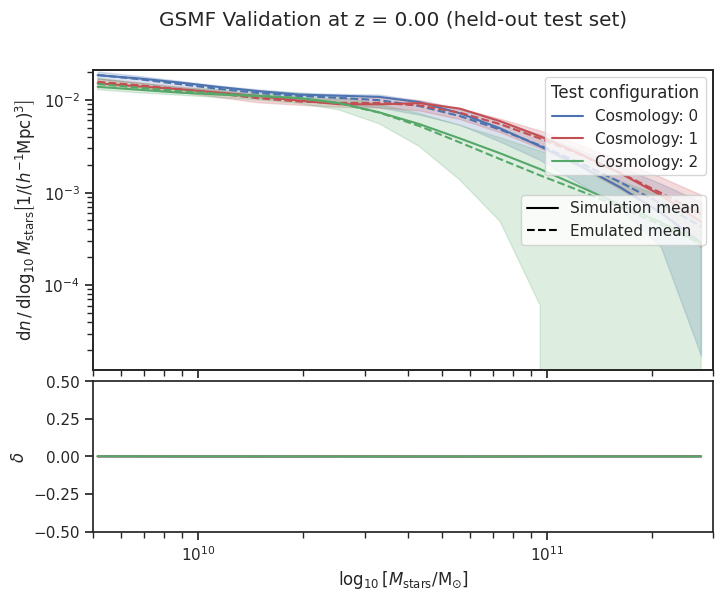

In [13]:
# Validate at z=0 (last snapshot) using HELD-OUT test set
snap_idx_test = -1  # z=0

input_params = params_test[:3]
target_vals = gsmf_y_vals[test_sim_indices[:3], snap_idx_test, :]

pred_mean, pred_quant = emulate(gsmf_model_list[snap_idx_test], input_params)

plt_strings = plot_strings('GSMF')
mlim1, mlim2 = mass_conds('GSMF')
validation_plot(gsmf_y_ind, np.log10(target_vals), np.log10(pred_mean), np.log10(pred_quant),
                *plt_strings, mlim1, mlim2, 'log', 'log')
plt.suptitle(f'GSMF Validation at z = {z_all[snap_idx_test]:.2f} (held-out test set)')
plt.savefig('../plots/GSMF_multiz_valid.png', bbox_inches='tight')

### GSMF Redshift Interpolation

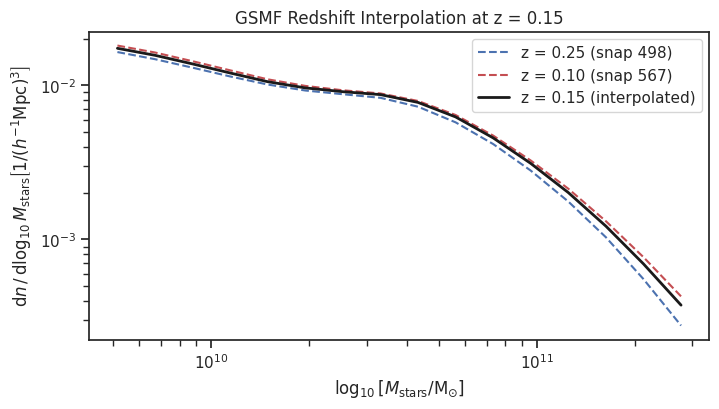

In [14]:
# Interpolate at an intermediate redshift
z_interp = 0.15  # Between z=0.1 (snap 567) and z=0.25 (snap 498)

test_param = params_test[0:1]  # Single test point (held-out)
input_with_z = np.hstack([test_param, np.array([[z_interp]])])

pred_interp, pred_interp_err = emu_redshift(
    input_params_and_redshift=input_with_z,
    sepia_model_list=gsmf_model_list,
    sepia_data_list=gsmf_data_list,
    z_all=z_all
)

print(f'Interpolated at z = {z_interp}')
print(f'Prediction shape: {pred_interp.shape}')

# Compare with bracketing snapshots
snap_lo = np.where(z_all >= z_interp)[0][-1]
snap_hi = snap_lo + 1
pred_lo, _ = emulate(gsmf_model_list[snap_lo], test_param)
pred_hi, _ = emulate(gsmf_model_list[snap_hi], test_param)

plt.figure(figsize=(8, 4))
plt.plot(gsmf_y_ind, np.log10(pred_lo.flatten()), 'b--', label=f'z = {z_all[snap_lo]:.2f} (snap {SNAPSHOT_IDS[snap_lo]})')
plt.plot(gsmf_y_ind, np.log10(pred_hi.flatten()), 'r--', label=f'z = {z_all[snap_hi]:.2f} (snap {SNAPSHOT_IDS[snap_hi]})')
plt.plot(gsmf_y_ind, np.log10(pred_interp.flatten()), 'k-', lw=2, label=f'z = {z_interp:.2f} (interpolated)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(plt_strings[1])
plt.ylabel(plt_strings[2])
plt.title(f'GSMF Redshift Interpolation at z = {z_interp}')
plt.legend()
plt.savefig('../plots/GSMF_z_interp.png', bbox_inches='tight')

# Emulate CGD -- All Snapshots

In [16]:
# Data prep for CGD
plt_strings_cgd = plot_strings('CGD')
rlim1, rlim2 = mass_conds('CGD')
rad_cond = np.where((radius > rlim1) & (radius < rlim2))[0]

cgd_y_ind = radius[rad_cond]

# Prepare 3D array for training
cgd_y_vals = cgd_arr_all[:, :, rad_cond]

print(f'CGD training data: {cgd_y_vals.shape}')
print(f'  (num_sims={cgd_y_vals.shape[0]}, num_snaps={cgd_y_vals.shape[1]}, num_bins={cgd_y_vals.shape[2]})')

In [17]:
model_dir_cgd = 'model/CGD/'

# CGD data is all NaN at z>0.5 (snap indices 0-5); valid from index 6 onward (snaps 415-624)
cgd_z_start_idx = 6

if do_train:
    os.makedirs(model_dir_cgd, exist_ok=True)
    z_index_range = np.arange(len(SNAPSHOT_IDS))[cgd_z_start_idx:]
    print(f'Training CGD for z_index_range={z_index_range} (snaps {[SNAPSHOT_IDS[i] for i in z_index_range]})')
    do_gp_train_multiple(model_dir=model_dir_cgd,
                         p_train_all=params_train,
                         y_vals_all=cgd_y_vals[train_sim_indices],
                         y_ind_all=cgd_y_ind,
                         z_index_range=z_index_range)
else:
    print('Training skipped. Set do_train=True to train.')

In [18]:
z_index_range = np.arange(len(SNAPSHOT_IDS))[cgd_z_start_idx:]

cgd_model_list, cgd_data_list = load_model_multiple(
    model_dir=model_dir_cgd,
    p_train_all=params_train,
    y_vals_all=cgd_y_vals[train_sim_indices],
    y_ind_all=cgd_y_ind,
    z_index_range=z_index_range
)

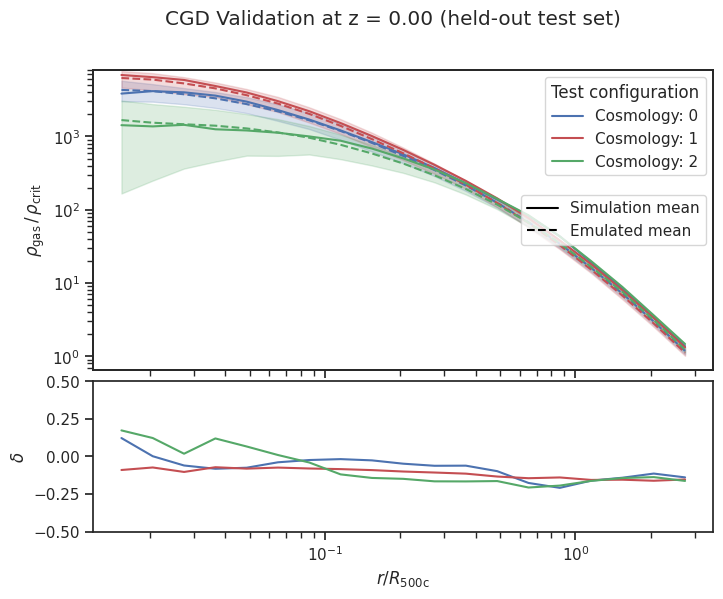

In [19]:
# Validate CGD at z=0 using HELD-OUT test set
snap_idx_test = -1  # last model in cgd_model_list corresponds to z=0

input_params = params_test[:3]
target_vals = cgd_y_vals[test_sim_indices[:3], -1, :]  # last snapshot in full data

pred_mean, pred_quant = emulate(cgd_model_list[snap_idx_test], input_params)

plt_strings_cgd = plot_strings('CGD')
validation_plot(cgd_y_ind, target_vals, pred_mean, pred_quant,
                *plt_strings_cgd, None, None, 'log', 'log', (0.05, 1.2))
plt.suptitle(f'CGD Validation at z = {z_all[-1]:.2f} (held-out test set)')
plt.savefig('../plots/CGD_multiz_valid.png', bbox_inches='tight')

In [20]:
# Data prep for fGas
plt_strings_fgas = plot_strings('fGas')
mlim1_fg, mlim2_fg = mass_conds('fGas')
mass_cond_fg = np.where((10**log_halo_mass > mlim1_fg) & (10**log_halo_mass < mlim2_fg))[0]

fgas_y_ind = 10**log_halo_mass[mass_cond_fg]

# Prepare 3D array, apply interpolation
fgas_y_vals = np.zeros((num_sims, len(SNAPSHOT_IDS), len(mass_cond_fg)))
for snap_idx in range(len(SNAPSHOT_IDS)):
    fgas_snap = gas_fr_arr_all[:, snap_idx, :]
    fgas_snap_extra = fill_nan_with_interpolation(fgas_snap, 'cubic')
    fgas_y_vals[:, snap_idx, :] = fgas_snap_extra[:, mass_cond_fg]

print(f'fGas training data: {fgas_y_vals.shape}')

In [21]:
model_dir_fgas = 'model/fGas/'

# fGas: snap 205 (z~2) has 20/39 bad sims; snaps 224-275 have 1-2 bad sims
# Fully clean from snap index 4 onward (snap 310, z<=1.0)
fgas_z_start_idx = 4

if do_train:
    os.makedirs(model_dir_fgas, exist_ok=True)
    z_index_range = np.arange(len(SNAPSHOT_IDS))[fgas_z_start_idx:]
    print(f'Training fGas for z_index_range={z_index_range} (snaps {[SNAPSHOT_IDS[i] for i in z_index_range]})')
    do_gp_train_multiple(model_dir=model_dir_fgas,
                         p_train_all=params_train,
                         y_vals_all=fgas_y_vals[train_sim_indices],
                         y_ind_all=fgas_y_ind,
                         z_index_range=z_index_range)
else:
    print('Training skipped. Set do_train=True to train.')

In [22]:
z_index_range = np.arange(len(SNAPSHOT_IDS))[fgas_z_start_idx:]

fgas_model_list, fgas_data_list = load_model_multiple(
    model_dir=model_dir_fgas,
    p_train_all=params_train,
    y_vals_all=fgas_y_vals[train_sim_indices],
    y_ind_all=fgas_y_ind,
    z_index_range=z_index_range
)

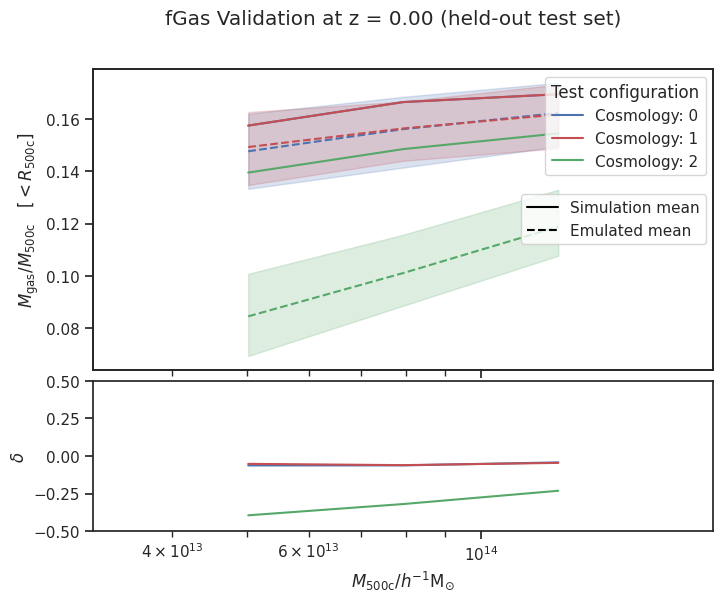

In [23]:
# Validate fGas at z=0 using HELD-OUT test set
snap_idx_test = -1  # last model in fgas_model_list corresponds to z=0

input_params = params_test[:3]
target_vals = fgas_y_vals[test_sim_indices[:3], -1, :]  # last snapshot in full data

pred_mean, pred_quant = emulate(fgas_model_list[snap_idx_test], input_params)

plt_strings_fgas = plot_strings('fGas')
mlim1_fg, mlim2_fg = mass_conds('fGas')
validation_plot(fgas_y_ind, target_vals, pred_mean, pred_quant,
                *plt_strings_fgas, mlim1_fg, mlim2_fg, 'log', 'linear')
plt.suptitle(f'fGas Validation at z = {z_all[-1]:.2f} (held-out test set)')
plt.savefig('../plots/fGas_multiz_valid.png', bbox_inches='tight')

# Emulate CGED -- All Snapshots

In [24]:
# Data prep for CGED
plt_strings_cged = plot_strings('CGED')
rlim1_cged, rlim2_cged = mass_conds('CGED')
rad_cond_cged = np.where((radius > rlim1_cged) & (radius < rlim2_cged))[0]

cged_y_ind = radius[rad_cond_cged]

cged_y_vals = cged_arr_all[:, :, rad_cond_cged]

print(f'CGED training data: {cged_y_vals.shape}')

In [25]:
do_train = True
model_dir_cged = 'model/CGED/'

# CGED shares the same cluster data validity as CGD: valid from index 6 onward (z<=0.5)
cged_z_start_idx = 6

if do_train:
    os.makedirs(model_dir_cged, exist_ok=True)
    z_index_range = np.arange(len(SNAPSHOT_IDS))[cged_z_start_idx:]
    print(f'Training CGED for z_index_range={z_index_range} (snaps {[SNAPSHOT_IDS[i] for i in z_index_range]})')
    do_gp_train_multiple(model_dir=model_dir_cged,
                         p_train_all=params_train,
                         y_vals_all=cged_y_vals[train_sim_indices],
                         y_ind_all=cged_y_ind,
                         z_index_range=z_index_range)
else:
    print('Training skipped. Set do_train=True to train.')

MCMC sampling: 100%|██████████| 1000/1000 [00:07<00:00, 140.42it/s]


In [26]:
z_index_range = np.arange(len(SNAPSHOT_IDS))[cged_z_start_idx:]

cged_model_list, cged_data_list = load_model_multiple(
    model_dir=model_dir_cged,
    p_train_all=params_train,
    y_vals_all=cged_y_vals[train_sim_indices],
    y_ind_all=cged_y_ind,
    z_index_range=z_index_range
)

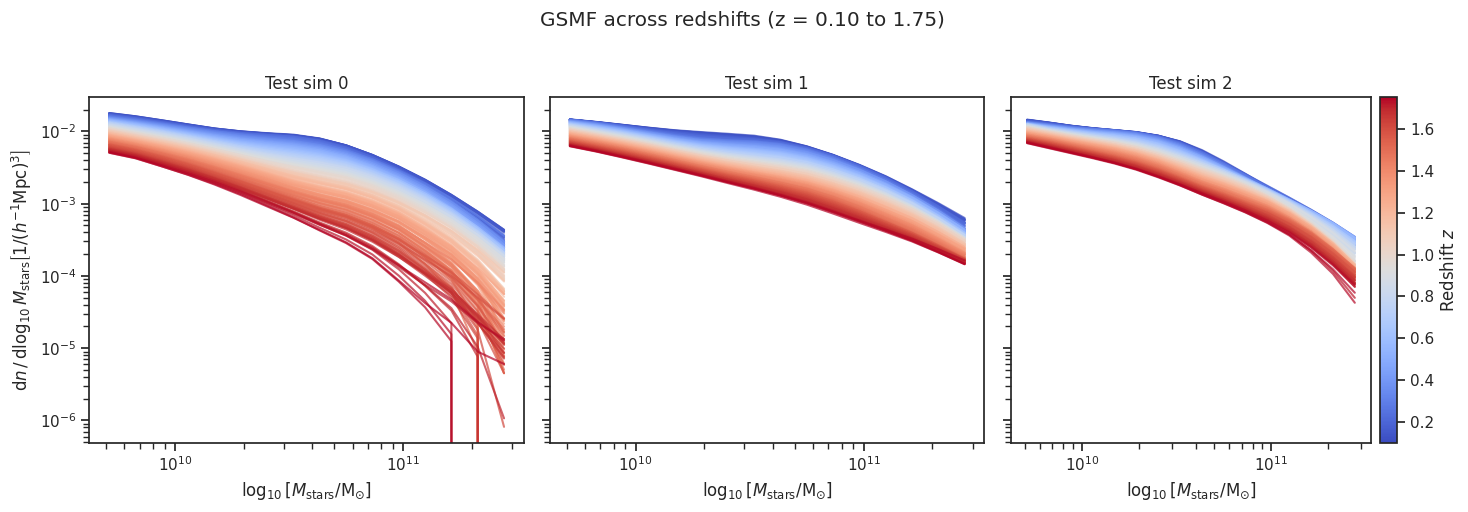

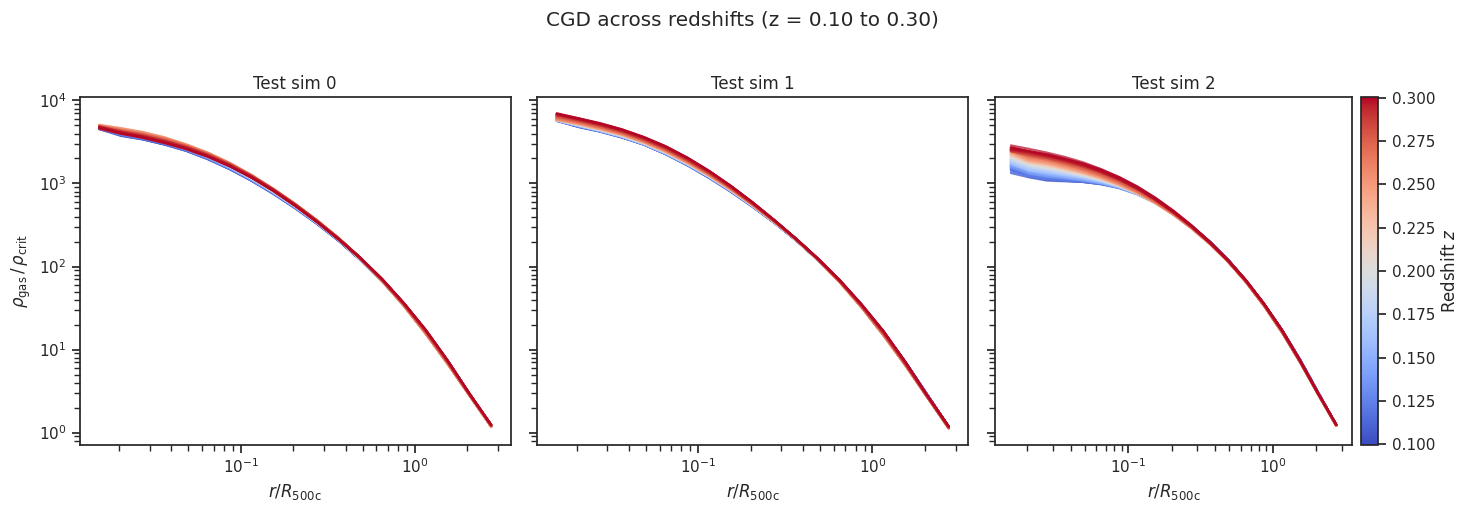

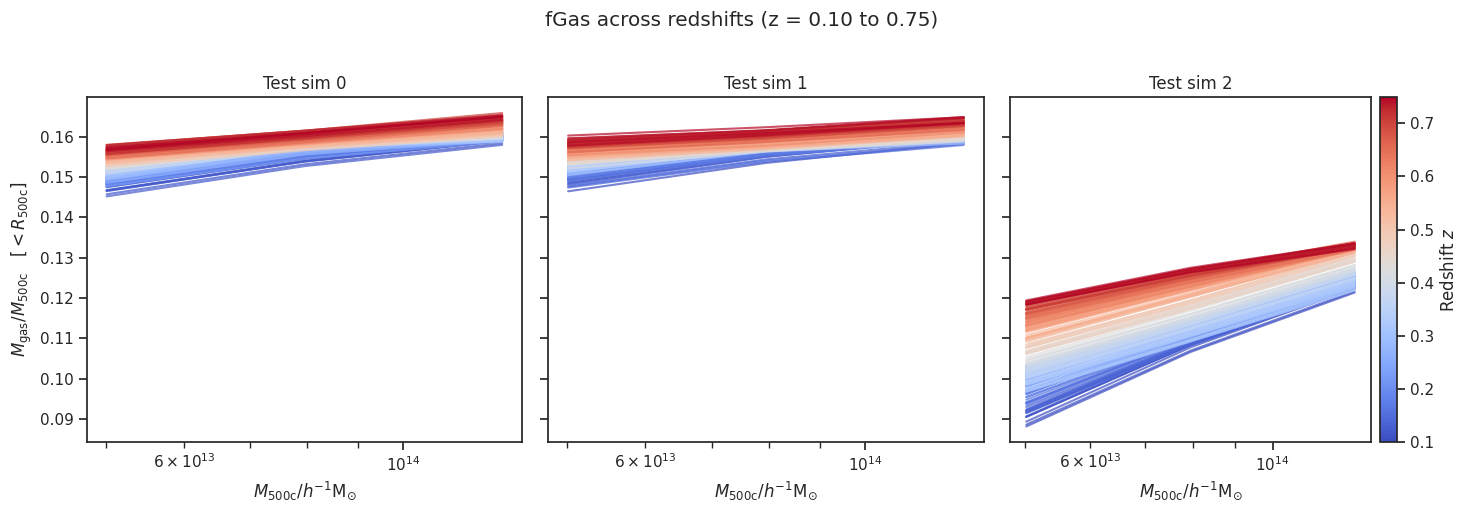

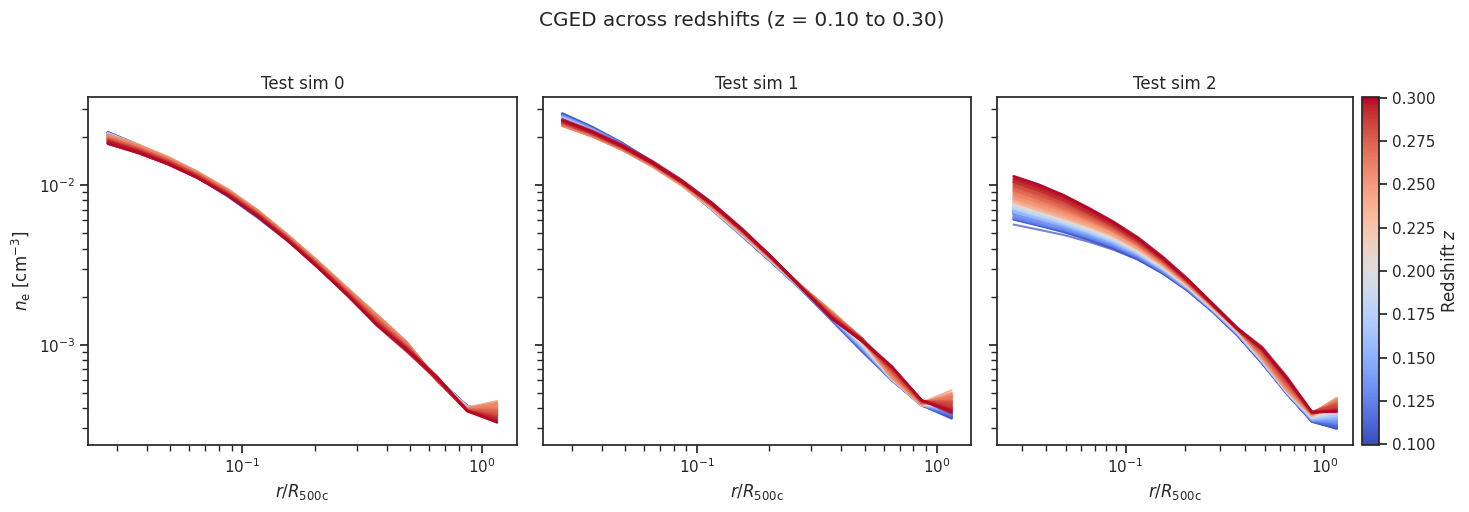

In [27]:
# Redshift interpolation for ALL summary statistics
# Each statistic has its own valid z range due to data availability
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Restricted z arrays for statistics with limited redshift coverage
cgd_z_all = z_all[cgd_z_start_idx:]
fgas_z_all = z_all[fgas_z_start_idx:]
cged_z_all = z_all[cged_z_start_idx:]

stats_config = [
    ('GSMF', gsmf_model_list, gsmf_data_list, gsmf_y_ind, z_all),
    ('CGD',  cgd_model_list,  cgd_data_list,  cgd_y_ind,  cgd_z_all),
    ('fGas', fgas_model_list, fgas_data_list, fgas_y_ind, fgas_z_all),
    ('CGED', cged_model_list, cged_data_list, cged_y_ind, cged_z_all),
]

test_params = params_test[:3]

for stat_name, model_list, data_list, y_ind, z_arr in stats_config:
    z_grid = np.linspace(z_arr[-2], z_arr[1], 200)
    plt_str = plot_strings(stat_name)
    
    norm = mcolors.Normalize(vmin=z_grid.min(), vmax=z_grid.max())
    cmap = cm.coolwarm
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    for j in range(3):
        ax = axes[j]
        for z_test in z_grid:
            input_with_z = np.hstack([test_params[j:j+1], np.array([[z_test]])])
            pred, _ = emu_redshift(input_with_z, model_list, data_list, z_arr)
            plot_vals = np.log10(pred.flatten()) if stat_name == 'GSMF' else pred.flatten()
            ax.plot(y_ind, plot_vals, alpha=0.7, color=cmap(norm(z_test)))
        ax.set_xscale('log')
        if stat_name != 'fGas':
            ax.set_yscale('log')
        ax.set_xlabel(plt_str[1])
        if j == 0:
            ax.set_ylabel(plt_str[2])
        ax.set_title(f'Test sim {j}')
    
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes[j], pad=0.02)
    cbar.set_label('Redshift $z$')
    
    plt.suptitle(f'{stat_name} across redshifts (z = {z_grid.min():.2f} to {z_grid.max():.2f})', y=1.02)
    plt.tight_layout()
    plt.savefig(f'../plots/{stat_name}_z_sweep.png', bbox_inches='tight')
    print(f'Saved ../plots/{stat_name}_z_sweep.png')